In [1]:
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt

rcParams = {'font.size': 20, 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}

plt.rcParams.update(rcParams)

def Parse_Diff_Read_Alignment_Summary(fp):
    lines = open(fp).readlines()
    d = {}
    for l in lines:
        l = l.replace("\n","").split("\t")
        d[l[0]] = int(l[2])
    return d

In [2]:
data_dir = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/'
genomes = listdir(data_dir+'Non_Synechococcus_Alignments/')
op = []

for g in genomes:
    hot_springs = listdir(data_dir+'Non_Synechococcus_Alignments/'+g+'/')
    for h in hot_springs:
        try:
            summary_file = data_dir+'Non_Synechococcus_Alignments/'+g+'/'+h+'/Genome.'+g+'.Summary'
            d = Parse_Diff_Read_Alignment_Summary(summary_file)
            d['Genome'] = g
            d['Hotspring'] = h.replace("_FD","")
            op.append(d)
        except FileNotFoundError:
            print(g, h)

hot_springs = listdir(data_dir+'Differential_Read_Counting/')
for h in hot_springs:
    if h.startswith("Hot"):
        try:
            d = Parse_Diff_Read_Alignment_Summary(data_dir+'Differential_Read_Counting/'+h+'/Genome.OSA.Summary')
            d['Genome'] = "OSA"
            d['Hotspring'] = h.replace("_Diff_Read_Count","")
            op.append(d)

            d = Parse_Diff_Read_Alignment_Summary(data_dir+'Differential_Read_Counting/'+h+'/Genome.OSB.Summary')
            d['Genome'] = "OSB"
            d['Hotspring'] = h.replace("_Diff_Read_Count","")
            op.append(d)
        except FileNotFoundError:
            print(h)
df_diff_read_count = pd.DataFrame(data = op)
df_diff_read_count['Orphaned_Reads'] = (df_diff_read_count['Orphaned Reads in Both Genomes'] + 
                                        df_diff_read_count['Orphaned Reads in Only One Genome '])
df_diff_read_count['Mispaired_Reads'] = (df_diff_read_count['Mispaired Reads in Both Genomes'] + 
                                         df_diff_read_count['Mispaired Reads in Only One Genome '])
df_diff_reads_sum = df_diff_read_count[['Genome', 'Hotspring', 'Orphaned_Reads', 'Mispaired_Reads']]
df_diff_reads_sum = df_diff_reads_sum.set_index(['Genome','Hotspring'])

Roseiflexus HotsprottomLayer_FD
Roseiflexus Hotspr20SampleP4_FD
Roseiflexus HotsprSampleR4cd_FD


In [3]:
read_counts_non_syn = data_dir + 'Non-Synechococcus-Alignments-Counts.txt'

non_synechococcus_alignments = []
for l in open(read_counts_non_syn).readlines():
    l = l.replace("\n","").split()
    counts = int(l[0])
    if l[1] == "total":
        continue
    splits = l[1].split("/")
    genome = splits[1]
    hot_spring = splits[2].replace("_FD","")
    d = {'Genome':genome, "Hotspring":hot_spring,"Alignments":counts}
    non_synechococcus_alignments.append(d)
df_non_syn = pd.DataFrame(non_synechococcus_alignments)
df_non_syn = df_non_syn.set_index(['Genome', 'Hotspring'])

In [4]:
read_counts_syn = data_dir + 'Synechococcus-Alignments-Counts.txt'

synechococcus_alignments = []
for l in open(read_counts_syn).readlines():
    l = l.replace("\n","").split()
    counts = int(l[0])
    if l[1] == "total":
        continue
    splits = l[1].split("/")
    hot_spring = splits[1].replace("_Diff_Read_Count","")
    if "osa" in l[1]: genome = "OSA"
    if "osb" in l[1]: genome = "OSB"
    d = {'Genome':genome, "Hotspring":hot_spring,"Alignments":counts}
    synechococcus_alignments.append(d)
df_syn = pd.DataFrame(synechococcus_alignments)
df_syn = df_syn.set_index(['Genome','Hotspring'])

In [5]:
df_summary = df_diff_reads_sum.join(df_non_syn.append(df_syn))
df_summary['Percent_Orphaned'] = df_summary['Orphaned_Reads']/df_summary['Alignments']*100.0
df_summary['Percent_Mispaired'] = df_summary['Mispaired_Reads']/df_summary['Alignments']*100.0

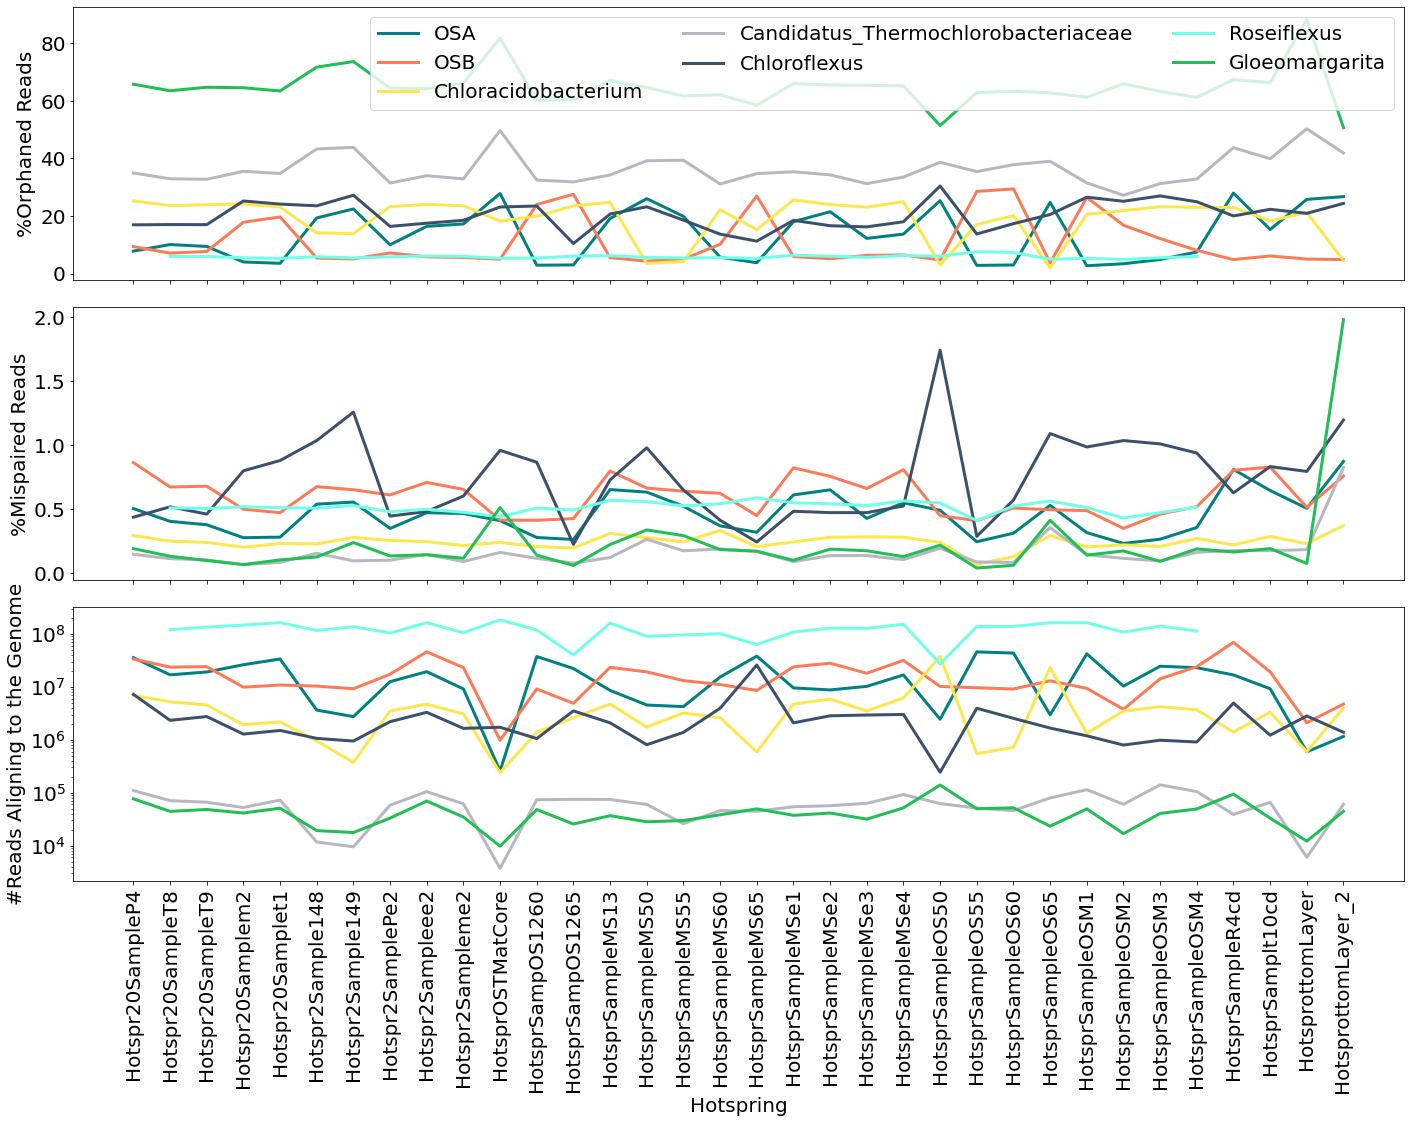

In [12]:
fig,ax = plt.subplots(3,1,figsize = (24,20))

T = df_summary[['Percent_Orphaned']].reset_index().drop_duplicates(subset = ['Genome', 'Hotspring']).pivot(
    index = 'Hotspring', columns = 'Genome',values = 'Percent_Orphaned')
T = T.reset_index().rename(columns = {'Chloracidobacterium_thermophilum_B':'Chloracidobacterium'})
T = T.set_index('Hotspring')
Genome_Order = ['OSA', 'OSB', 'Chloracidobacterium', 'Candidatus_Thermochlorobacteriaceae', 
                'Chloroflexus', 'Roseiflexus', 'Gloeomargarita']

T[Genome_Order].plot(kind = 'line', figsize = (16,10), linewidth = 3, ax = ax[0], 
                     color = ['teal','#FC7A57','#FDE74C','#B7B6C2','#3A506B','#6FFFE9','#20BF55'])
ax[0].legend(ncol = 3)
ax[0].set_xticks(range(0,len(T)))
ax[0].set_xticklabels([], rotation = 90)
ax[0].set_xlabel('')
ax[0].set_ylabel('%Orphaned Reads')

T = df_summary[['Percent_Mispaired']].reset_index().drop_duplicates(subset = ['Genome', 'Hotspring']).pivot(
    index = 'Hotspring', columns = 'Genome',values = 'Percent_Mispaired')
T = T.reset_index().rename(columns = {'Chloracidobacterium_thermophilum_B':'Chloracidobacterium'})
T = T.set_index('Hotspring')
Genome_Order = ['OSA', 'OSB', 'Chloracidobacterium', 'Candidatus_Thermochlorobacteriaceae', 
                'Chloroflexus', 'Roseiflexus', 'Gloeomargarita']

T[Genome_Order].plot(kind = 'line', figsize = (16,10), linewidth = 3, ax = ax[1], legend = False,
                     color = ['teal','#FC7A57','#FDE74C','#B7B6C2','#3A506B','#6FFFE9','#20BF55'])
ax[1].set_xticks(range(0,len(T)))
ax[1].set_xticklabels([], rotation = 90)
ax[1].set_xlabel('')
ax[1].set_ylabel('%Mispaired Reads')

T = df_non_syn.append(df_syn).reset_index().drop_duplicates(subset = ['Genome', 'Hotspring']).pivot(
    index = 'Hotspring', columns = 'Genome',values = 'Alignments')
T = T.reset_index().rename(columns = {'Chloracidobacterium_thermophilum_B':'Chloracidobacterium'})
T = T.set_index('Hotspring')

T[Genome_Order].plot(kind = 'line', figsize = (20,16), linewidth = 3, ax = ax[2], legend = False,
                     color = ['teal','#FC7A57','#FDE74C','#B7B6C2','#3A506B','#6FFFE9','#20BF55'])
ax[2].set_xticks(range(0,len(T)))
ax[2].set_xticklabels(T.index.tolist(), rotation = 90)
ax[2].set_yscale('log')
ax[2].set_ylabel('#Reads Aligning to the Genome')

fig.tight_layout()

fig.savefig('/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/\
Synechococcus-Paper/Orphaned_and_Mispaired_Reads_Cyanobacteria.pdf')